**Scarping and Cleaning the Data**

The goal of this notebook is to scrape arXiv preprints that are associated with a [*mathematical subject class*](https://en.wikipedia.org/wiki/Mathematics_Subject_Classification), and clean and preprocess the data which will later be used for a multi-label text classification task. The goal will be to predict the [MSC (Mathematical Subject Classification)](https://mathscinet.ams.org/mathscinet/msc/msc2020.html) code based on the (cleaned) titles. A "full" MSC code is a 5-character code which pins down a very specific mathematical topic. But shorter 2 and 3-character codes are available too. 

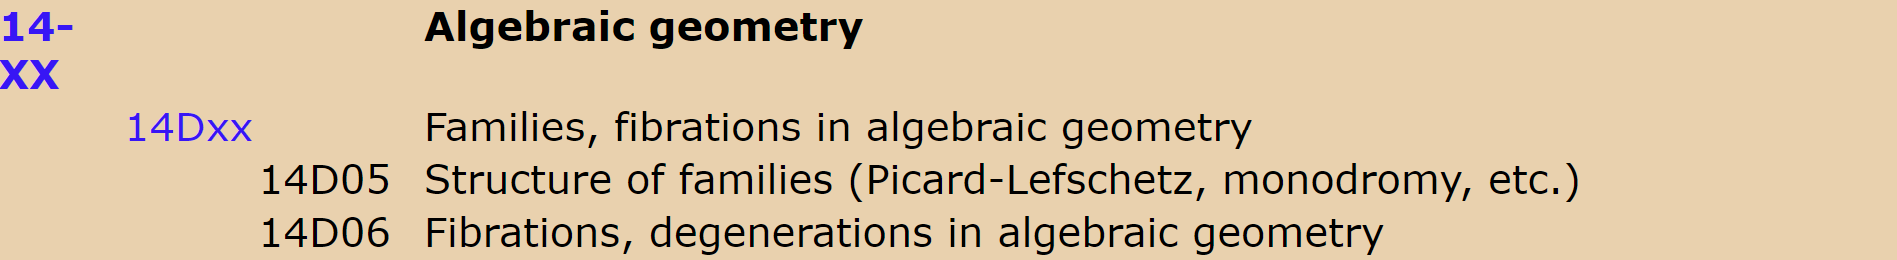

A full 5-character MSC code consists of two digits, an upper-case letter and then two more digits. **We shall focus on the 3-character MSC codes which have two digits followed by an upper-case letter, e.g. 14D, 37F, 55R etc.** First, we import necessary libraries, and we retrieve all such [MSC classes as of 2020](https://zbmath.org/static/msc2020.pdf).  

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  #default='warn'  #To avoide SettingWithCopyWarning

from PyPDF2 import PdfReader
import arxiv
import time

# nltk.download('stopwords')          #Uncomment if necessary
from nltk.corpus import stopwords

from unidecode import unidecode
import re
import random

#######################################################

reader=PdfReader('./data/msc2020.pdf')                     #Parsing the complete list of MSC2020.
n_pages=len(reader.pages)
df=pd.DataFrame(columns=['class','description'])

#We are interested in 3-character MSC codes. 
#The function below detects them in the form of the head subject, e.g. 14Gxx 
#which itself is divided into more specific topics (full MSC codes of length 5).  
def isMSC_xx(string):                        
    if len(string)==5 and string[0:2].isnumeric() and string[2].isupper() and string[3:5]=='xx':
        return True
    return False

for page_number in range(n_pages):
    page_content=reader.pages[page_number].extract_text().split('\n')  #Splitting the page into lines. 
    for line in page_content:
        line_reduced=line.split('[')[0]                    #Avoiding expressions such as '[See also...]'
        head=line_reduced.split(' ')[0]
        if isMSC_xx(head):
            MSC=head[:3]
            description=line_reduced.removeprefix(head)
            df.loc[df.shape[0]]=[MSC,description]
df.to_csv('./data/MSCclasses.csv')
print(f'The total number of (2nd level, 3-character) MSC classes is {df.shape[0]}.')
df

The total number of (2nd level, 3-character) MSC classes is 537.


,class,description
0,00A,General and miscellaneous speci c topics
1,00B,Conference proceedings and collections of art...
2,01A,History of mathematics and mathematicians
3,03A,Philosophical aspects of logic and foundations
4,03B,General logic
...,...,...
532,97K,"Education of combinatorics, graph theory, pro..."
533,97M,Education of mathematical modeling and applic...
534,97N,Education of numerical mathematics
535,97P,Computer science (educational aspects)


To scrape data from arXiv, we use the [arXiv package](https://pypi.org/project/arxiv/) to access the arXiv API. Based on the documentation of this package, an output `result` obtained from `Client.results` involves the metadata below. To obtain a particular field, the [query syntax documentation](https://info.arxiv.org/help/api/user-manual.html#query_details) from the arXiv API user manual should be utilized.   

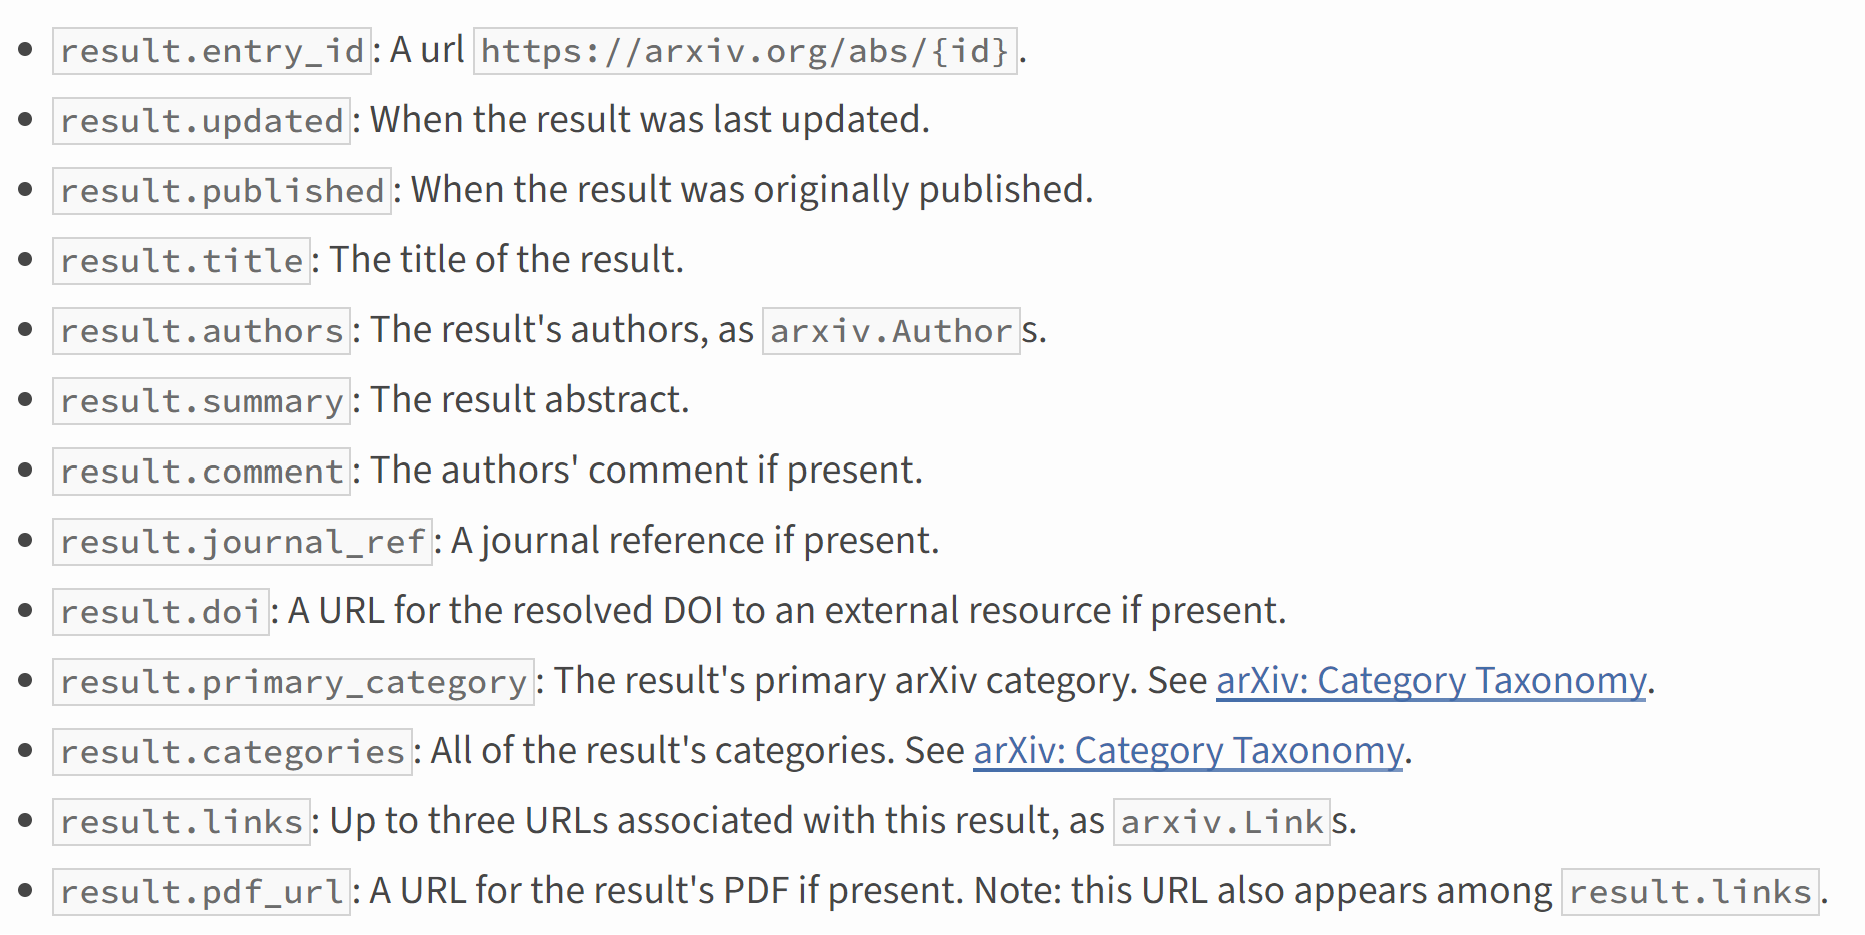

Notice that MSC class is not among the fields. Instead, we see the *arXiv category* which is of the form `<Archive>.<Subject Class>`, for instance `math.DS`, `cs.LG` etc. The [categories of math archive](https://arxiv.org/category_taxonomy) are usually coarser than MSC classes. The latter, assuming specified for that preprint upon submission, can be retrieved from `result.categories` which includes arXiv categories (both primary and non-primary) as well as MSC classes (if available). The next cell demonstrates a basic example where 20 preprints for which `math.AG` is a category are scraped, and their primary categories are printed as well as all other categories and MSC classes (if any). Notice that any existing MSC class should appear in the last entry of `result.categories`.    

In [2]:
# Construct the default API client.
client = arxiv.Client()

#Search for the 20 most recent articles matching the provided category. 
search = arxiv.Search(
  query = "cat:math.AG",
  max_results = 20,
  sort_by = arxiv.SortCriterion.SubmittedDate
)

results = client.results(search)

# `results` is a generator; you can iterate over its elements one by one...
for result in results:
    print(result.primary_category,result.categories)

math.DG ['math.DG', 'math.AG', 'math.CV', '53C07, 58E15']
math.AG ['math.AG']
math.CO ['math.CO', 'math.AG', 'math.RT', '14T15 (Primary) 05B35, 16G20, 14N20, 14T20 (Secondary)']
math.CT ['math.CT', 'math.AG', 'math.QA', 'math.RA', 'math.RT', '18G80, 18M05 (Primary) 14L30, 16W22, 16T05 (Secondary)']
math.MG ['math.MG', 'math.AG', '14P10, 32V40']
math.SG ['math.SG', 'hep-th', 'math.AG', '53D45, 53D37 (Primary) 14N35, 14N10 (Secondary)']
math.AG ['math.AG', 'math.DS']
math.AG ['math.AG']
hep-th ['hep-th', 'math.AG', 'math.DG', 'math.GT', 'math.SG']
math.AG ['math.AG', 'math.NT']
math.AG ['math.AG', '14D23 (Primary)']
math.AG ['math.AG', '14T10, 13P15, 14-04']
math.AG ['math.AG', 'math.AT']
math.RA ['math.RA', 'math.AG', 'math.PR', '60L10 (Primary) 14P99 17A30 16T05 (Secondary)']
math.NT ['math.NT', 'math.AG', 'math.DS', '11G50, 14J50, 37P15, 37P30']
math.NT ['math.NT', 'math.AG', 'Primary: 14G05, Secondary: 11J25 and 11J97']
math.AC ['math.AC', 'math.AG', 'Primary 13H15, 14C17, 13A30, 14C

To gather preprints which are potentially associated with an MSC class, we iterate over all categories of the math archive, and we aggregate the queries. There will be repeated entries because some preprints are cross-listed (some even under non-math archives). Those will be dropped later during data cleaning.   

In [3]:
math_categories=['math.AC', 'math.AG', 'math.AP', 'math.AT', 'math.CA', 'math.CO', 'math.CT', 'math.CV',
                'math.DG', 'math.DS', 'math.FA', 'math.GM', 'math.GN', 'math.GR', 'math.GT', 'math.HO', 'math.IT',
                'math.KT', 'math.LO', 'math.MG', 'math.MP', 'math.NA', 'math.NT', 'math.OA', 'math.OC', 'math.PR',
                'math.QA', 'math.RA', 'math.RT', 'math.SG', 'math.SP', 'math.ST']
print(f"The number of math arXiv categories is {len(math_categories)} (while the number of MSC classes is {len(df['class'].to_list())}).")

The number of math arXiv categories is 32 (while the number of MSC classes is 537).


In [4]:
#Initializing a data frame for saving the scraped data
data=pd.DataFrame(columns=['primary_category','title','authors','url','last_updated','MSC'])


#Constructing an API client.
client = arxiv.Client(num_retries=5,page_size=1500,delay_seconds=10)
    
print('Start fetching the data:')
time_start=time.time()    
for category in math_categories:
    
    #Search for the 12,000 most recent articles matching the provided category. (The API's limit is 300,000 results.)
    search = arxiv.Search(
      query = "cat:"+category,
      max_results = 12000,
      sort_by = arxiv.SortCriterion.SubmittedDate
    )
    
    results = client.results(search)  #This is an iterable.                 
    
    double_list=list(map(lambda r:[r.primary_category,r.title,r.authors,r.entry_id,r.updated,r.categories[-1]],results))
    
    data=pd.concat([data,
                    pd.DataFrame(double_list,columns=['primary_category','title','authors','url','last_updated','MSC'])]
                   ,ignore_index=True)
    print(f'The category just scraped: {category}, the time elapsed so far: {time.time()-time_start}')

Start fetching the data:


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.AC, the time elapsed so far: 250.73470067977905


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.AG, the time elapsed so far: 540.0070054531097
The category just scraped: math.AP, the time elapsed so far: 730.2123167514801


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.AT, the time elapsed so far: 973.2163372039795
The category just scraped: math.CA, the time elapsed so far: 1175.3247890472412
The category just scraped: math.CO, the time elapsed so far: 1394.1341292858124


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.CT, the time elapsed so far: 1547.1172494888306


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.CV, the time elapsed so far: 1818.0847437381744


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.DG, the time elapsed so far: 2056.792612552643
The category just scraped: math.DS, the time elapsed so far: 2285.472546339035
The category just scraped: math.FA, the time elapsed so far: 2506.2588675022125
The category just scraped: math.GM, the time elapsed so far: 2571.064980506897
The category just scraped: math.GN, the time elapsed so far: 2660.9954442977905


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.GR, the time elapsed so far: 2937.1663784980774


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.GT, the time elapsed so far: 3172.6754450798035
The category just scraped: math.HO, the time elapsed so far: 3242.5827510356903
The category just scraped: math.IT, the time elapsed so far: 3454.3213379383087


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.KT, the time elapsed so far: 3563.6891083717346
The category just scraped: math.LO, the time elapsed so far: 3762.2318716049194
The category just scraped: math.MG, the time elapsed so far: 3944.275534629822


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.MP, the time elapsed so far: 4175.468411445618
The category just scraped: math.NA, the time elapsed so far: 4372.431064128876


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.NT, the time elapsed so far: 4672.738920211792
The category just scraped: math.OA, the time elapsed so far: 4866.970031499863
The category just scraped: math.OC, the time elapsed so far: 5062.2617309093475
The category just scraped: math.PR, the time elapsed so far: 5243.54439163208
The category just scraped: math.QA, the time elapsed so far: 5436.268796920776


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.RA, the time elapsed so far: 5639.505921602249


Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2
Bozo feed; consider handling: document declared as utf-8, but parsed as iso-8859-2


The category just scraped: math.RT, the time elapsed so far: 5943.886517047882
The category just scraped: math.SG, the time elapsed so far: 6081.219998836517
The category just scraped: math.SP, the time elapsed so far: 6232.096318483353
The category just scraped: math.ST, the time elapsed so far: 6432.451142072678


In [5]:
print(f'In total, we fetched {data.shape[0]} preprints for our raw dataset.')
data.head()

In total, we fetched 342781 preprints for our raw dataset.


,primary_category,title,authors,url,last_updated,MSC
0,math.AC,Hilbert series and degrees of regularity of Oi...,"[Antonio Corbo Esposito, Rosa Fera, Francesco ...",http://arxiv.org/abs/2311.18626v1,2023-11-30 15:32:01+00:00,math.AC
1,math.AC,Formal lifting of dualizing complexes and cons...,[Shiji Lyu],http://arxiv.org/abs/2311.18196v1,2023-11-30 02:29:02+00:00,math.AC
2,math.AC,Conditions for Virtually Cohen--Macaulay Simpl...,"[Jay Yang, Adam Van Tuyl]",http://arxiv.org/abs/2311.17806v1,2023-11-29 16:55:55+00:00,math.CO
3,math.AC,Density functions for epsilon multiplicity and...,"[Suprajo Das, Sudeshna Roy, Vijaylaxmi Trivedi]",http://arxiv.org/abs/2311.17679v1,2023-11-29 14:41:02+00:00,"Primary 13H15, 14C17, 13A30, 14C20, Secondary ..."
4,math.AC,Conditions of multiplicity and applications fo...,"[Koji Matsushita, Sora Miyashita]",http://arxiv.org/abs/2311.17387v2,2023-12-01 04:48:25+00:00,"Primary 13H10, Secondary 13M05"


Next, we begin the data preprocessing. We start with adding columns for version, [arXiv identifier](https://info.arxiv.org/help/arxiv_identifier.html) and the year_month of the original upload. The version appears at the end of the URL string while the year-month is retrieved from the identifier. The (version less) arXiv identifier was of the form `arXiv:<Archive>.<Subject Class>/YYMMnumber` before 2007, and is in the form of `arXiv:YYMM.number` currently. We shall extract them from the url as `<Archive>.<Subject Class>/YYMMnumber` and `YYMM.number` respectively. We then write the identifiers to the dataframe along with year_month as ``YY-MM``.

In [6]:
data['version']=data['url'].apply(lambda url:int(url.removeprefix('http://arxiv.org/abs/').split('v')[-1]))

#Be careful, there is an archive solv-int (Exactly Solvable and Integrable Systems) which contains the letter v. 
data['identifier']=data['url'].apply(lambda url:url.removeprefix('http://arxiv.org/abs/').removesuffix('v'+url.removeprefix('http://arxiv.org/abs/').split('v')[-1]))

def extract_year_month(identifier):
    if len(identifier.split('.')[0])==4:         #For the current identifier scheme.  
        return identifier.split('.')[0][:2]+'-'+identifier.split('.')[0][2:]
    else:                                        #For pre-2007 identifier scheme. 
        return identifier.split('/')[1][:2]+'-'+identifier.split('/')[1][2:4]    
data['year_month']=data['identifier'].apply(extract_year_month)
data.head()

,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month
0,math.AC,Hilbert series and degrees of regularity of Oi...,"[Antonio Corbo Esposito, Rosa Fera, Francesco ...",http://arxiv.org/abs/2311.18626v1,2023-11-30 15:32:01+00:00,math.AC,1,2311.18626,23-11
1,math.AC,Formal lifting of dualizing complexes and cons...,[Shiji Lyu],http://arxiv.org/abs/2311.18196v1,2023-11-30 02:29:02+00:00,math.AC,1,2311.18196,23-11
2,math.AC,Conditions for Virtually Cohen--Macaulay Simpl...,"[Jay Yang, Adam Van Tuyl]",http://arxiv.org/abs/2311.17806v1,2023-11-29 16:55:55+00:00,math.CO,1,2311.17806,23-11
3,math.AC,Density functions for epsilon multiplicity and...,"[Suprajo Das, Sudeshna Roy, Vijaylaxmi Trivedi]",http://arxiv.org/abs/2311.17679v1,2023-11-29 14:41:02+00:00,"Primary 13H15, 14C17, 13A30, 14C20, Secondary ...",1,2311.17679,23-11
4,math.AC,Conditions of multiplicity and applications fo...,"[Koji Matsushita, Sora Miyashita]",http://arxiv.org/abs/2311.17387v2,2023-12-01 04:48:25+00:00,"Primary 13H10, Secondary 13M05",2,2311.17387,23-11


Now that submissions' versions are available, we can use them to drop some preprints that make grandiose claims such as a proof of the Riemann hypothesis or Fermat's last theorem. We detect them through the abnormally high number of versions. 

In [7]:
data.sort_values(by=['version'],ascending=False).head(10)

,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month
192703,math.NT,A hypothetical upper bound for the solutions o...,[Apoloniusz Tyszka],http://arxiv.org/abs/0901.2093v152,2014-10-20 12:23:40+00:00,"03D20, 11U05",152,0901.2093,09-01
10517,math.AC,Some Comments around The Examples against The ...,[Susumu Oda],http://arxiv.org/abs/0706.1138v99,2022-11-30 12:55:41+00:00,math.AG,99,0706.1138,07-06
10638,math.AC,Bounds of some real (complex) solution of a fi...,[Apoloniusz Tyszka],http://arxiv.org/abs/math/0702558v86,2009-12-04 18:42:21+00:00,"03B30, 12D99, 12L12, 14P05, 15A06, 26C10",86,math/0702558,07-02
193204,math.AC,Bounds of some real (complex) solution of a fi...,[Apoloniusz Tyszka],http://arxiv.org/abs/math/0702558v86,2009-12-04 18:42:21+00:00,"03B30, 12D99, 12L12, 14P05, 15A06, 26C10",86,math/0702558,07-02
129757,math.GM,The lost proof of Fermat's last theorem,[Andrea Ossicini],http://arxiv.org/abs/1704.06335v73,2022-11-28 07:38:50+00:00,"11D41 (primary), 11G05 (secondary)",73,1704.06335,17-04
131171,math.GM,A certain continuity property of the residues ...,[Hisanobu Shinya],http://arxiv.org/abs/0706.0357v67,2023-11-18 08:31:02+00:00,11M26,67,0706.0357,07-06
130878,math.GM,High Degree Diophantine Equation c^q=a^p+b^p,[Sheng-Ping Wu],http://arxiv.org/abs/0809.2293v64,2021-01-07 05:28:18+00:00,"11D41 (Primary), 13M10 (Secondary)",64,0809.2293,08-09
192423,math.LO,Two conjectures on integer arithmetic and thei...,[Apoloniusz Tyszka],http://arxiv.org/abs/0911.0384v58,2010-12-01 20:45:36+00:00,"03B30, 11D99, 11U05",58,0911.0384,09-11
129188,math.GM,A lower bound for the modulus of the Dirichlet...,[Yuri Heymann],http://arxiv.org/abs/2002.04395v47,2023-09-27 11:00:00+00:00,"11M26, 11Axx",47,2002.04395,20-02
130290,math.GM,On the nature of Mersenne fluctuations,[U. Merkel],http://arxiv.org/abs/1309.5272v47,2023-03-03 12:36:40+00:00,math.GM,47,1309.5272,13-09


Now we remove all versions of any preprint with more than 10 versions. Then, for each of the remaining preprints, we only keep the latest version via dropping duplicate identifiers. 

In [8]:
#Removing preprints with abnormally high number of versions
current_row_number=data.shape[0]
too_many_v_list=data.index[data['version']>10].to_list()
bad_identifiers=set(data.loc[too_many_v_list,'identifier'])
data=data[data['identifier'].apply(lambda identifier:identifier not in bad_identifiers)]
data=data.sort_values(by=['version'],ascending=False,ignore_index=True)
print(f'Removing preprints with more than 10 versions: the number of records dropped is {current_row_number-data.shape[0]}.')

#Keeping only the oldest version
current_row_number=data.shape[0]
data.drop_duplicates(subset=['identifier'],keep='first',inplace=True,ignore_index=True)
print(f'Keeping the last arXiv version only: the number of records dropped is {current_row_number-data.shape[0]}.')
data.head()

Removing preprints with more than 10 versions: the number of records dropped is 323.
Keeping the last arXiv version only: the number of records dropped is 73347.


,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month
0,math.QA,Jones polynomials of torus knots via DAHA,[Ivan Cherednik],http://arxiv.org/abs/1111.6195v10,2012-08-04 05:00:24+00:00,math.RT,10,1111.6195,11-11
1,math.GN,Branched surfaces homeomorphic to Reeb spaces ...,[Naoki Kitazawa],http://arxiv.org/abs/2106.02037v10,2022-08-13 02:09:39+00:00,math.GT,10,2106.02037,21-06
2,cs.LO,On the system CL12 of computability logic,[Giorgi Japaridze],http://arxiv.org/abs/1203.0103v10,2015-07-25 15:42:03+00:00,math.LO,10,1203.0103,12-03
3,math.LO,Reachability for infinite time Turing machines...,"[Merlin Carl, Benjamin Rin, Philipp Schlicht]",http://arxiv.org/abs/1802.05734v10,2020-04-23 09:08:19+00:00,cs.LO,10,1802.05734,18-02
4,math.QA,Noncommutative Complex Structures on Quantum H...,[Réamonn Ó Buachalla],http://arxiv.org/abs/1108.2374v10,2015-11-05 10:41:53+00:00,math.AG,10,1108.2374,11-08


There are many preprints for which the authors have not specified MSC classes. Those will be dropped. For the rest, we keep the first three characters of any provided MSC in a new column. 

In [9]:
def isFullMSC(string):                        #Is the string a full MSC string, e.g. 20E18.        
    if len(string)==5 and string[0:2].isnumeric() and string[2].isupper() and string[0:2].isnumeric():
        return True
    return False

def extractMSC(FullMSC_all):                  #Detecting terms of the form 16Rxx and returning the first three characters.
    terms=FullMSC_all.split(' ')              #Each term ends with ',' or ',\n'
    return list(set([term.strip('\n').strip(',')[0:3] for term in terms if isFullMSC(term.strip('\n').strip(','))]))
        
data['MSC']=data['MSC'].apply(extractMSC)
current_row_number=data.shape[0]
data=data[data['MSC'].apply(lambda string:len(string)>0)]
data=data.sort_values(by=['primary_category'],ignore_index=True)   #Sorting based on the primary category.
print(f'Removing submissions with no MSC: the number of records dropped is {current_row_number-data.shape[0]}.')
data.head()

Removing submissions with no MSC: the number of records dropped is 140490.


,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month
0,astro-ph.CO,After the Dark Ages,[Jürg Fröhlich],http://arxiv.org/abs/2205.11929v1,2022-05-24 09:43:48+00:00,[83F],1,2205.11929,22-05
1,astro-ph.EP,4th Body-Induced Secondary Resonance Overlappi...,"[Bhanu Kumar, Rodney L. Anderson, Rafael de la...",http://arxiv.org/abs/2309.06073v2,2023-09-16 23:05:11+00:00,[70M],2,2309.06073,23-09
2,astro-ph.EP,Nekhoroshev estimates for the orbital stabilit...,"[Alessandra Celletti, Irene De Blasi, Christos...",http://arxiv.org/abs/2112.06045v1,2021-12-11 18:33:44+00:00,"[34C, 37N, 70F]",1,2112.06045,21-12
3,astro-ph.EP,Three-dimensional Lagrangian Coherent Structur...,"[Jack Tyler, Alexander Wittig]",http://arxiv.org/abs/2209.11561v1,2022-09-23 12:36:12+00:00,[70F],1,2209.11561,22-09
4,astro-ph.EP,Relative Equilibria and Periodic Orbits in a B...,"[Lennard F. Bakker, Nicholas J. Freeman]",http://arxiv.org/abs/2306.00273v1,2023-06-01 01:21:10+00:00,"[37C, 70F]",1,2306.00273,23-06


We begin cleaning the titles. The first step is to make them lower case, normalize the accents, and remove all the stop words. 

In [10]:
data['cleaned_title']=data['title']

#The stop words in our list are lower case, so we first turn everything lower case. 
data['cleaned_title']=data['cleaned_title'].apply(lambda title:title.lower())


#Normalizing the accents.
data['cleaned_title']=data['cleaned_title'].apply(lambda string:unidecode(string))


#Removing stop words
STOPWORDS = list(stopwords.words('english'))

def remove_stop_words(string):
    cleaned_string=''
    terms=string.split(' ')
    for term in terms:
        if (term not in STOPWORDS) and len(term)>0:  #Avoiding empty string '' which comes up in terms if there are consecutive spaces. 
            cleaned_string+=' '+term
    cleaned_string=cleaned_string.removeprefix(' ')  #Killing any space at the beginning of the string
    return cleaned_string

data['cleaned_title']=data['cleaned_title'].apply(remove_stop_words)

Occasionally, the LaTeX math environment has been used in the titles. We are going to remove all those parts which are between `$` signs.   

In [11]:
def remove_math(string):
    terms=string.split('$')
    if terms[0]=='' and terms[-1]=='' and len(terms)==3:   #I.e. the whole title is in the math environment. 
        return ''
    
    cleaned_string=''                  #Initializing
    between_dollar_signs=False        
    for term in terms:
        if not between_dollar_signs:
            cleaned_string+=term
            between_dollar_signs=True  #The next term will be between dollar signs
        else:
            between_dollar_signs=False
    return cleaned_string

data['cleaned_title']=data['cleaned_title'].apply(remove_math)
current_row_number=data.shape[0]
data=data[data['cleaned_title']!='']  #Records where the title is entirely in the math environment are removed. 
print(f'Removing preprints with title entirely in the math environment: the number of records dropped is {current_row_number-data.shape[0]}.')

Removing preprints with title entirely in the math environment: the number of records dropped is 2.


Next, we remove some special characters. 

In [12]:
def modify(string):
    
    #The following characters will be removed.
    string=string.translate({ord(i): None for i in ":;,!?.'(){}`[]/*^$"})
    string=string.translate({ord(i): None for i in '"'})  #The signle quote was removed above, now the double quote.
    
    #The following characters will be replaced with space.
    temp2="-=&+\n"                                
    string=string.translate({ord(i): ' ' for i in "-=&+"}) 
    
    return string

data['cleaned_title']=data['cleaned_title'].apply(modify)
data.head()

,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month,cleaned_title
0,astro-ph.CO,After the Dark Ages,[Jürg Fröhlich],http://arxiv.org/abs/2205.11929v1,2022-05-24 09:43:48+00:00,[83F],1,2205.11929,22-05,dark ages
1,astro-ph.EP,4th Body-Induced Secondary Resonance Overlappi...,"[Bhanu Kumar, Rodney L. Anderson, Rafael de la...",http://arxiv.org/abs/2309.06073v2,2023-09-16 23:05:11+00:00,[70M],2,2309.06073,23-09,4th body induced secondary resonance overlappi...
2,astro-ph.EP,Nekhoroshev estimates for the orbital stabilit...,"[Alessandra Celletti, Irene De Blasi, Christos...",http://arxiv.org/abs/2112.06045v1,2021-12-11 18:33:44+00:00,"[34C, 37N, 70F]",1,2112.06045,21-12,nekhoroshev estimates orbital stability earths...
3,astro-ph.EP,Three-dimensional Lagrangian Coherent Structur...,"[Jack Tyler, Alexander Wittig]",http://arxiv.org/abs/2209.11561v1,2022-09-23 12:36:12+00:00,[70F],1,2209.11561,22-09,three dimensional lagrangian coherent structur...
4,astro-ph.EP,Relative Equilibria and Periodic Orbits in a B...,"[Lennard F. Bakker, Nicholas J. Freeman]",http://arxiv.org/abs/2306.00273v1,2023-06-01 01:21:10+00:00,"[37C, 70F]",1,2306.00273,23-06,relative equilibria periodic orbits binary ast...


Finally, we remove those records whose cleaned titles still have non-alphanumeric characters. 

In [13]:
def special_character_detection(string):
    terms=string.split(' ')
    for term in terms:
        if len(term)==0:             #Skipping empty string '' which comes up when the original string has consecutive spaces.
            continue
        if not term.isalnum():
            return True
    return False

current_row_number=data.shape[0]
data=data[data['cleaned_title'].apply(lambda title:not special_character_detection(title))]
print(f'Removing submissions whose cleaned titles still have non-alphanumeric characters: the number of records dropped is {current_row_number-data.shape[0]}.')

Removing submissions whose cleaned titles still have non-alphanumeric characters: the number of records dropped is 716.


At the end, we remove multiple spaces as well as any spaces existing at the beginning or at the end of cleaned titles; and we save the processed data.

In [14]:
data['cleaned_title']=data['cleaned_title'].apply(lambda title:re.sub(' {2,}',' ',title))
data['cleaned_title']=data['cleaned_title'].apply(lambda title:title.strip(' '))
data.to_csv('./data/data.csv',index=False)
print('The shape of the final dataset:',data.shape)
data.head()

The shape of the final dataset: (127903, 10)


,primary_category,title,authors,url,last_updated,MSC,version,identifier,year_month,cleaned_title
0,astro-ph.CO,After the Dark Ages,[Jürg Fröhlich],http://arxiv.org/abs/2205.11929v1,2022-05-24 09:43:48+00:00,[83F],1,2205.11929,22-05,dark ages
1,astro-ph.EP,4th Body-Induced Secondary Resonance Overlappi...,"[Bhanu Kumar, Rodney L. Anderson, Rafael de la...",http://arxiv.org/abs/2309.06073v2,2023-09-16 23:05:11+00:00,[70M],2,2309.06073,23-09,4th body induced secondary resonance overlappi...
2,astro-ph.EP,Nekhoroshev estimates for the orbital stabilit...,"[Alessandra Celletti, Irene De Blasi, Christos...",http://arxiv.org/abs/2112.06045v1,2021-12-11 18:33:44+00:00,"[34C, 37N, 70F]",1,2112.06045,21-12,nekhoroshev estimates orbital stability earths...
3,astro-ph.EP,Three-dimensional Lagrangian Coherent Structur...,"[Jack Tyler, Alexander Wittig]",http://arxiv.org/abs/2209.11561v1,2022-09-23 12:36:12+00:00,[70F],1,2209.11561,22-09,three dimensional lagrangian coherent structur...
4,astro-ph.EP,Relative Equilibria and Periodic Orbits in a B...,"[Lennard F. Bakker, Nicholas J. Freeman]",http://arxiv.org/abs/2306.00273v1,2023-06-01 01:21:10+00:00,"[37C, 70F]",1,2306.00273,23-06,relative equilibria periodic orbits binary ast...


A sanity check: Pick a random URL and compare with the recorded data. 

In [16]:
random_index=random.randint(0,data.shape[0]-1)
print(f"URL: {data['url'][random_index]}")
print(f"arXiv identifier: {data['identifier'][random_index]}")
print(f"Title: {data['title'][random_index]}")
print(f"Simplified title: {data['cleaned_title'][random_index]}")
print(f"MSC classes: {data['MSC'][random_index]}")

URL: http://arxiv.org/abs/0801.4248v1
arXiv identifier: 0801.4248
Title: On non-formality of a simply-connected symplectic 8-manifold
Simplified title: non formality simply connected symplectic 8 manifold
MSC classes: ['57R', '55P', '55S']
